# Sentiment Normalization
### Coded by Marco Basile

In [31]:
import pandas as pd

reducedPapers = pd.read_csv(
    "../processedData/processedData.csv",
    sep=',',
    index_col=0
)

reducedPapers.dropna(subset = ['processedText'], inplace = True, how='any')
reducedPapers.reset_index(drop=True, inplace=True)
reducedPapers['timePeriod'] = pd.to_datetime(reducedPapers['timePeriod'])
reducedPapers.tail()

,timePeriod,processedText
23039,2000-01-01,viscount craigavon ask majesty government impo...
23040,2000-01-01,utterly wrong change name ruc remove royal cro...
23041,2000-01-01,chris bryant rhondda much hate agree liberal d...
23042,2000-01-01,also confirm majesty government make clear pri...
23043,2000-01-01,king bridgwater minister recall debate invasio...


In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

royalWords = (
"""
    king
    queen
    royalty
    majesty
    crown
    prince
    princess
    regent
    monarch
    highness
""")
royalWords = royalWords.split()

def isRoyalTopic(text):
    if len(text.split()) < 4:
        return 0
    for word in text.split():
        if word in royalWords:
            return 1
    return 0

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score > 0:
        return 1  # positivo
    elif compound_score < 0:
        return -1  # negativo
    else:
        return 0  # neutro

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Siga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
reducedPapers['royal'] = reducedPapers['processedText'].apply(isRoyalTopic)
reducedPapers.drop(reducedPapers[reducedPapers.royal == 0].index, inplace=True)
reducedPapers.tail()

,timePeriod,processedText,royal
23039,2000-01-01,viscount craigavon ask majesty government impo...,1
23040,2000-01-01,utterly wrong change name ruc remove royal cro...,1
23041,2000-01-01,chris bryant rhondda much hate agree liberal d...,1
23042,2000-01-01,also confirm majesty government make clear pri...,1
23043,2000-01-01,king bridgwater minister recall debate invasio...,1


In [34]:
reducedPapers['sentiment'] = reducedPapers['processedText'].apply(get_sentiment)
reducedPapers.tail()

,timePeriod,processedText,royal,sentiment
23039,2000-01-01,viscount craigavon ask majesty government impo...,1,1
23040,2000-01-01,utterly wrong change name ruc remove royal cro...,1,-1
23041,2000-01-01,chris bryant rhondda much hate agree liberal d...,1,-1
23042,2000-01-01,also confirm majesty government make clear pri...,1,1
23043,2000-01-01,king bridgwater minister recall debate invasio...,1,1


In [35]:
reducedPapers.to_csv('../processedData/sentimentData_normalized.csv', index=True, sep=',', columns=['timePeriod', 'sentiment'])

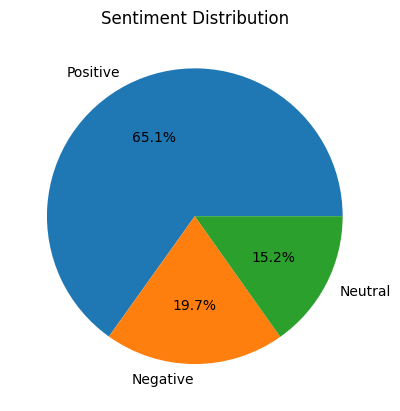

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../processedData/sentimentData_normalized.csv')

sentiment_counts = df['sentiment'].value_counts()
total_count = sentiment_counts.sum()
positive_percentage = (sentiment_counts[1] / total_count) * 100
negative_percentage = (sentiment_counts[-1] / total_count) * 100
neutral_percentage = (sentiment_counts[0] / total_count) * 100

sentiment_data = pd.DataFrame({
    'Sentiment': ['Positive', 'Negative', 'Neutral'],
    'Percentage': [positive_percentage, negative_percentage, neutral_percentage]
})

plt.pie(sentiment_data['Percentage'], labels=sentiment_data['Sentiment'], autopct='%1.1f%%', shadow=False)
plt.title('Sentiment Distribution')
plt.show()

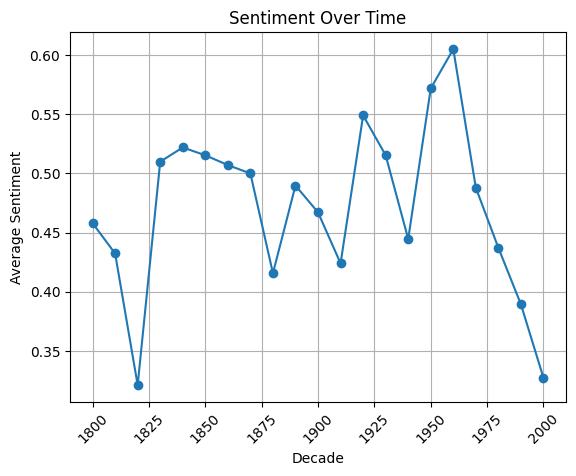

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../processedData/sentimentData_normalized.csv')

df['timePeriod'] = pd.to_datetime(df['timePeriod'])

df['decade'] = df['timePeriod'].dt.year // 10 * 10
df_decade = df.groupby('decade')['sentiment'].mean().reset_index()

plt.plot(df_decade['decade'], df_decade['sentiment'], marker='o')
plt.xlabel('Decade')
plt.ylabel('Average Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


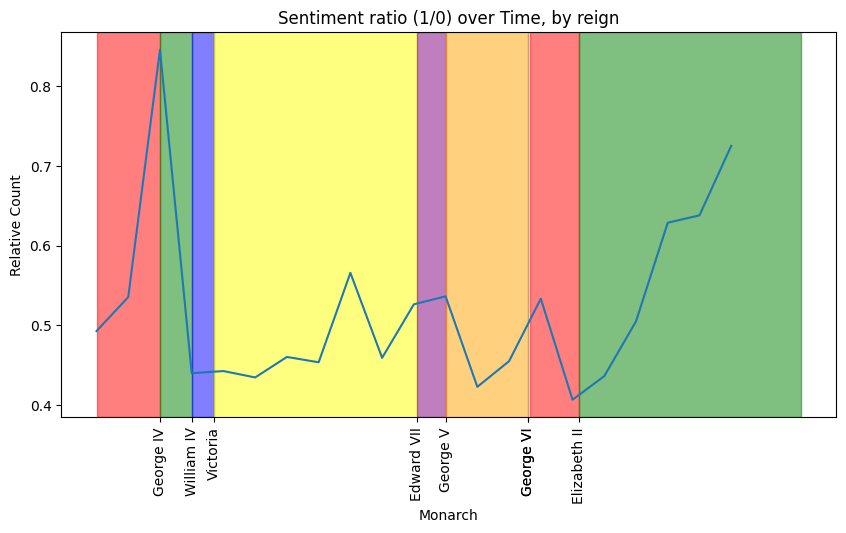

In [38]:
monarchs = [('George III', '1760-10-25', '1820-01-29'),            ('George IV', '1820-01-29', '1830-06-26'),            ('William IV', '1830-06-26', '1837-06-20'),            ('Victoria', '1837-06-20', '1901-01-22'),            ('Edward VII', '1901-01-22', '1910-05-06'),            ('George V', '1910-05-06', '1936-01-20'),            ('Edward VIII', '1936-01-20', '1936-12-11'),            ('George VI', '1936-12-11', '1952-02-06'),            ('Elizabeth II', '1952-02-06', '2021-09-08')]

x = [pd.to_datetime(monarch[1]).year for monarch in monarchs]

reducedPapers['timePeriod'] = pd.to_datetime(reducedPapers['timePeriod'])
reducedPapers_sentiment_1 = reducedPapers[reducedPapers['sentiment'] < 0.5]
reducedPapers_sentiment_0 = reducedPapers[reducedPapers['sentiment'] > 0.5]
count_by_time_1 = reducedPapers_sentiment_1.groupby('timePeriod').count()
count_by_time_0 = reducedPapers_sentiment_0.groupby('timePeriod').count()
relative_count = count_by_time_1['sentiment'] / count_by_time_0['sentiment']
y = relative_count.loc[pd.to_datetime(monarchs[0][1]):pd.to_datetime(monarchs[-1][2])]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y.index.year, y.values, label='Sentiment 1 / Sentiment 0')

ax.set_xticks(x)
ax.set_xticklabels([monarch[0] for monarch in monarchs], rotation=90, ha='center')

ax.set_xlabel('Monarch')
ax.set_ylabel('Relative Count')
ax.set_title('Sentiment ratio (1/0) over Time, by reign')

ax.axvspan(1800, 1820, color='red', alpha=0.5)
ax.axvspan(1820, 1830, color='green', alpha=0.5)
ax.axvspan(1830, 1837, color='blue', alpha=0.5)
ax.axvspan(1837, 1901, color='yellow', alpha=0.5)
ax.axvspan(1901, 1910, color='purple', alpha=0.5)
ax.axvspan(1910, 1936, color='orange', alpha=0.5)
ax.axvspan(1936, 1936, color='grey', alpha=0.5)
ax.axvspan(1936.5, 1952, color='red', alpha=0.5)
ax.axvspan(1952, 2022, color='green', alpha=0.5)

plt.show()